In [1]:
# USAGE
# python train_siamese_network.py
%config Completer.use_jedi = False

# import the necessary packages
import tensorflow as tf
from pyimagesearch.siamese_network import *
from pyimagesearch import config
from pyimagesearch import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import cv2

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0
print(trainX.shape)
print(trainY.shape)
print(testX.shape)

[INFO] loading MNIST dataset...
(60000, 28, 28)
(60000,)
(10000, 28, 28)


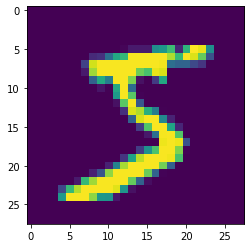

In [6]:
plt.imshow(trainX[0])

In [7]:
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
print(trainX.shape)
print(testX.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = utils.make_pairs(trainX, trainY)
(pairTest, labelTest) = utils.make_pairs(testX, testY)

[INFO] preparing positive and negative pairs...


In [9]:
pairTrain.shape

(120000, 2, 28, 28, 1)

In [10]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=config.IMG_SHAPE)
imgB = Input(shape=config.IMG_SHAPE)
# featureExtractor = build_siamese_model(config.IMG_SHAPE)
featureExtractor = build_vgg16(config.IMG_SHAPE, embeddingDim=48)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(utils.euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

[INFO] building siamese network...
[INFO] compiling model...


In [11]:
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=config.BATCH_SIZE, 
	epochs=config.EPOCHS)

[INFO] training model...
Epoch 1/100
1875/1875 [==============================] - 848s 452ms/step - loss: 0.3423 - accuracy: 0.8913 - val_loss: 0.1679 - val_accuracy: 0.9831
Epoch 2/100
1875/1875 [==============================] - 845s 451ms/step - loss: 0.1089 - accuracy: 0.9861 - val_loss: 0.0837 - val_accuracy: 0.9847
Epoch 3/100
1875/1875 [==============================] - 839s 447ms/step - loss: 0.0532 - accuracy: 0.9920 - val_loss: 0.0523 - val_accuracy: 0.9908
Epoch 4/100
 385/1875 [=====>........................] - ETA: 10:46 - loss: 0.0404 - accuracy: 0.9929

KeyboardInterrupt: 

In [ ]:
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(config.MODEL_PATH)

# plot the training history
print("[INFO] plotting training history...")
utils.plot_training(history, config.PLOT_PATH)